In [1]:
## imports 

import numpy as np
import pandas as pd
from scipy.special import lambertw as W1
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Input , Embedding
from keras.models import Model
from keras.models import Sequential
# import tensorflow as tf
# from keras.optimizers.legacy.adam import adam
import matplotlib.pyplot as plt
import seaborn as sns
from keras import callbacks 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from keras.initializers import initializer
from keras.optimizers import Nadam
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.losses import Loss
import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l2
# from tensorflow.keras import backend as K

In [2]:
## importing pre-processed data 

learn = pd.read_csv('/Users/debjyoti_mukherjee/Downloads/bell_learn.csv'
                    , index_col= 0)
test = pd.read_csv('/Users/debjyoti_mukherjee/Downloads/bell_test.csv'
                   , index_col = 0)

# learn = learn.sample(500)

In [8]:
learn.shape, test.shape

((610212, 22), (67801, 22))

In [9]:
data = pd.concat([learn, test], axis=0)

In [10]:
np.mean(data['bellGLM']), np.mean(data['ClaimNb'])

(0.05572372657312568, 0.05317892134811574)

In [11]:
## final Bell Deviance:

def Bell_Deviance(y_true, y_pred):
    eps =0    #1e-8  

    y_true = tf.reshape(y_true, (-1,1))
    y_pred = tf.reshape(y_pred, (-1,1))

    obs_zero = tf.boolean_mask(y_true, tf.equal(y_true, 0))
    pred_zero = tf.boolean_mask(y_pred, tf.equal(y_true, 0))

    obs_nonzero = tf.boolean_mask(y_true, tf.not_equal(y_true, 0))
    pred_nonzero = tf.boolean_mask(y_pred, tf.not_equal(y_true, 0))

    loss_zero = 2 * (-1 + tf.exp(tfp.math.lambertw(tf.cast(pred_zero,
                                             dtype = tf.float64))))

    loss_nonzero = 2 * (
    tf.exp(tfp.math.lambertw(tf.cast(pred_nonzero, dtype=tf.float64)))
    - tf.exp(tfp.math.lambertw(tf.cast(obs_nonzero, dtype=tf.float64))) +
    tf.math.log(
        (tfp.math.lambertw(tf.cast(obs_nonzero, dtype=tf.float64))/
        (tfp.math.lambertw(tf.cast(pred_nonzero, dtype=tf.float64))+eps))** 
        tf.cast(obs_nonzero, dtype=tf.float64)
    )
    )
    loss = tf.concat([loss_zero, loss_nonzero], axis=0)

    mean_loss = tf.reduce_mean(loss)

    return mean_loss


In [12]:
Bell_Deviance(learn['ClaimNb'],learn['bellGLM'])

2023-09-10 21:47:57.170504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-10 21:47:57.171870: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



<tf.Tensor: shape=(), dtype=float64, numpy=0.28819543059850866>

In [13]:
Bell_Deviance(test['ClaimNb'],test['bellGLM'])

<tf.Tensor: shape=(), dtype=float64, numpy=0.28359761726147104>

In [14]:
q0 = 7
Xdata = data[['AreaX','VehPowerX','VehAgeX','DrivAgeX','BonusMalusX'
              ,'VehGasX','DensityX']]
Xlearn  = learn[['AreaX','VehPowerX','VehAgeX','DrivAgeX','BonusMalusX'
                 ,'VehGasX','DensityX']]
Xtest  = test[['AreaX','VehPowerX','VehAgeX','DrivAgeX','BonusMalusX'
               ,'VehGasX','DensityX']]

In [15]:
## Choosing the right volume for EmbNN and CANN model:
Vlearn = np.log(learn['Exposure'])
Vtest = np.log(test['Exposure'])
lambda_hom = sum(learn['ClaimNb']/sum(learn['Exposure']))

CANN = 1        ## 0 =  EmbNN, 1 = CANN 

if (CANN == 1):
    Vlearn = np.log(learn['bellGLM'])
    Vtest = np.log(test['bellGLM'])
    lambda_hom = sum(learn['ClaimNb']/sum(learn['bellGLM']))

lambda_hom


0.9578401201961692

In [16]:
## Hyperparameter setup:

Brlabel = len(learn['VehBrandX'].unique())
Relabel = len(learn['RegionX'].unique())
q1 = 100
q2 = 75
q3 = 50
d = 2   ## Vary 1 or 2 
p = 0

In [17]:
## Embedding layer for categorical variables 
# the network architechture:

Design =  keras.layers.Input(shape=(q0,), name= 'design')
VehBrand = keras.layers.Input(shape= (1,))
Region = keras.layers.Input(shape= (1,))
LogVol = keras.layers.Input(shape= (1,), name='LogVol')
#
BrandEmb = keras.layers.Embedding(input_dim= Brlabel , 
        output_dim= d, input_length = 1, name = 'BrandEmb')(VehBrand)
Brand_Flat = keras.layers.Flatten(name = 'Brand_Flat')(BrandEmb)
RegionEmb = keras.layers.Embedding(input_dim= Relabel , output_dim= d, 
                        input_length = 1, name = 'RegionEmb')(Region)
Region_flat = keras.layers.Flatten(name = 'Region_Flat')(RegionEmb)
#
concate = keras.layers.Concatenate()([Design, Brand_Flat, Region_flat])
hidden1 = keras.layers.Dense(q1, activation='tanh')(concate)
hidden2 = keras.layers.Dense(q2, activation = 'tanh')(hidden1)
hidden3 = keras.layers.Dense(q3, activation = 'tanh')(hidden2)
Network = keras.layers.Dense(1, activation ='linear', use_bias=True, 
        weights= [np.zeros((q3,1)),  np.array((lambda_hom,))])(hidden3) 

Add= keras.layers.Add()([Network,LogVol])
Response = keras.layers.Dense(1, activation = keras.activations
                .exponential, dtype= "float64",trainable= False, 
            weights= [np.ones((1,1)), np.zeros(1,)])(Add)
model = keras.Model(inputs = [Design, VehBrand, Region, LogVol]
                    , outputs = Response)
model.compile(optimizer=keras.optimizers.Nadam(0.001)
              , loss = Bell_Deviance)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 BrandEmb (Embedding)           (None, 1, 2)         22          ['input_1[0][0]']                
                                                                                                  
 RegionEmb (Embedding)          (None, 1, 2)         44          ['input_2[0][0]']                
                                                                                              

In [18]:
cbs =  callbacks.EarlyStopping(monitor ="val_loss",  mode ="min", 
                        patience = 5, restore_best_weights = True) 
history = model.fit([Xlearn, learn['VehBrandX'], learn['RegionX'],
          Vlearn], (np.array(learn['ClaimNb'])).reshape(-1), 
             epochs=1000,batch_size= 100000, verbose = 2
            , validation_split=0.2,callbacks=cbs)

Epoch 1/1000


2023-09-10 21:48:12.998700: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-10 21:48:14.803748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-10 21:48:17.469182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 - 5s - loss: 0.3502 - val_loss: 0.3473 - 5s/epoch - 960ms/step
Epoch 2/1000
5/5 - 1s - loss: 0.3379 - val_loss: 0.3272 - 1s/epoch - 234ms/step
Epoch 3/1000
5/5 - 1s - loss: 0.3146 - val_loss: 0.3035 - 1s/epoch - 222ms/step
Epoch 4/1000
5/5 - 1s - loss: 0.2945 - val_loss: 0.2916 - 1s/epoch - 218ms/step
Epoch 5/1000
5/5 - 1s - loss: 0.2864 - val_loss: 0.2891 - 1s/epoch - 225ms/step
Epoch 6/1000
5/5 - 1s - loss: 0.2850 - val_loss: 0.2891 - 1s/epoch - 213ms/step
Epoch 7/1000
5/5 - 1s - loss: 0.2849 - val_loss: 0.2891 - 1s/epoch - 215ms/step
Epoch 8/1000
5/5 - 1s - loss: 0.2848 - val_loss: 0.2889 - 1s/epoch - 218ms/step
Epoch 9/1000
5/5 - 1s - loss: 0.2846 - val_loss: 0.2887 - 1s/epoch - 229ms/step
Epoch 10/1000
5/5 - 1s - loss: 0.2844 - val_loss: 0.2886 - 1s/epoch - 213ms/step
Epoch 11/1000
5/5 - 1s - loss: 0.2843 - val_loss: 0.2885 - 1s/epoch - 225ms/step
Epoch 12/1000
5/5 - 1s - loss: 0.2842 - val_loss: 0.2884 - 1s/epoch - 217ms/step
Epoch 13/1000
5/5 - 1s - loss: 0.2842 - val_loss: 

In [19]:
model.evaluate([Xlearn, learn['VehBrandX'], learn['RegionX'],
                 Vlearn], (np.array(learn['ClaimNb'])).reshape(-1)) , 

model.evaluate([Xtest, test['VehBrandX'], test['RegionX'],
                 Vtest], (np.array(test['ClaimNb'])).reshape(-1))

2119/2119 [==============================] - 40s 19ms/step - loss: 0.2711


(0.2738856077194214, 0.27105283737182617)

In [20]:
y_pred_data = (model.predict([Xdata , data['VehBrandX']
            , data['RegionX'], np.log(data['bellGLM'])]))

   21/21188 [..............................] - ETA: 1:52 

2023-09-10 22:03:55.679352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21188/21188 [==============================] - 89s 4ms/step


In [21]:
Bell_Deviance(data['ClaimNb'], y_pred_data)

<tf.Tensor: shape=(), dtype=float64, numpy=0.27360195990960207>

In [22]:
np.mean(y_pred_data)

0.055199446975010516

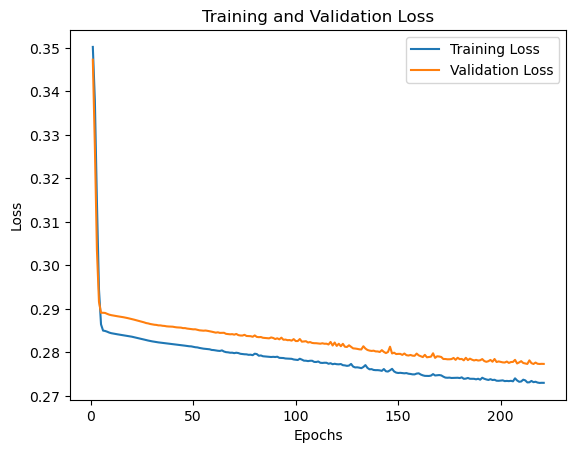

In [23]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='best')
plt.show()
